In [1]:
import torch
import torchvision
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# load dataset
train_data = datasets.FashionMNIST(
    root='./datasets/fashion_mnist',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root='./datasets/fashion_mnist',
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [4]:
def imshow(image, label) :
    plt.title(class_names[label])
    plt.imshow(image, cmap='binary')
    plt.axis('off')

In [5]:
# 60000 train and 10000 test images
len(train_data.data), len(test_data.data)

(60000, 10000)

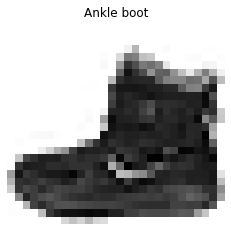

In [6]:
image, label = train_data[0] # see first image
imshow(image.reshape(28,28), label)

In [7]:
image.shape # color channel, height, width >> CHW

torch.Size([1, 28, 28])

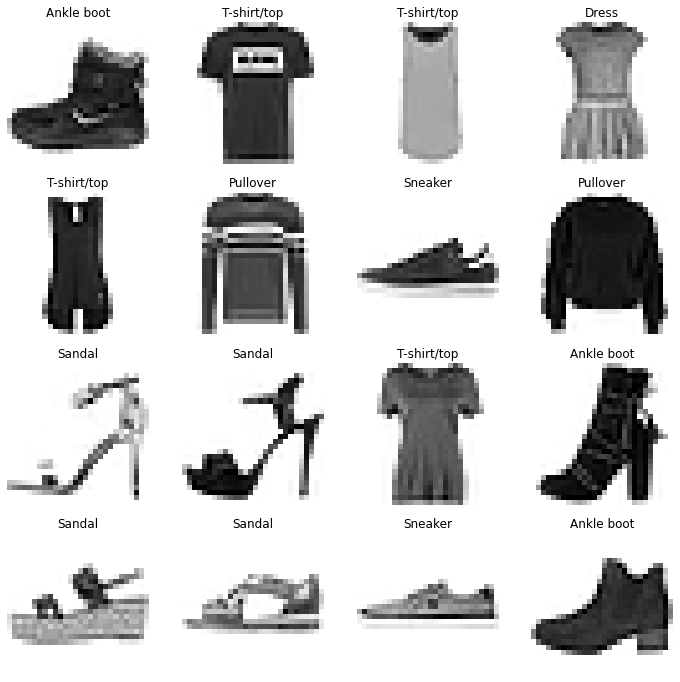

In [8]:
sample_image = 16
plt.figure(figsize=(12,12))
for image in range(sample_image) :
    plt.subplot(4,4,image+1)
    imshow(train_data.data[image], train_data.targets[image])

In [9]:
# dataloader 
from torch.utils.data import DataLoader

# turn to batches
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000014C9F7E4970>, <torch.utils.data.dataloader.DataLoader object at 0x0000014C9F7E4C70>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [10]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

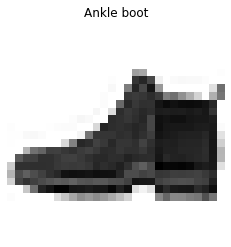

In [11]:
imshow(train_features_batch[0].reshape(28,28), train_labels_batch[0])

In [12]:
# build model
class FashionMnistV0(nn.Module) :
    def __init__(self, input_shape, hidden_unit, output_shape) :
        super().__init__()

        self.input_layer = nn.Flatten()
        self.dense_1 = nn.Linear(input_shape, hidden_unit)
        self.dense_2 = nn.Linear(hidden_unit, hidden_unit)
        self.dense_2 = nn.Linear(hidden_unit, output_shape)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x) :
        x = self.input_layer(x)
        x = self.dense_1(x)
        x = self.relu(x)
        x = self.dense_2(x)
        x = self.softmax(x)
        return x

In [13]:
model_v0 = FashionMnistV0(input_shape=28*28, hidden_unit=10, output_shape=len(class_names))
model_v0

FashionMnistV0(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (dense_1): Linear(in_features=784, out_features=10, bias=True)
  (dense_2): Linear(in_features=10, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [14]:
def accuracy_fn(y_true, y_pred) :
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_true)
    return acc*100

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v0.parameters(), lr=0.1)

Creating a function to time our experiments

In [16]:
from timeit import default_timer as timer

def print_train_time(start, end, device) :
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

Creating a training loop and training a model on batches of data

In [17]:
# progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)
start_time = timer()
epochs = 3

for epoch in tqdm(range(epochs)) :
    print(f'Epoch : {epoch}\n----')
    # for average Loss and Accuracy each epoch (reset every epoch)
    train_loss = 0 
    train_acc = 0

    # add a loop to loop through training batch
    for batch, (X, y) in enumerate(train_dataloader) : # X.shape = [32,1,28,28] NCHW = batch,chanel,hight,width
        model_v0.train()
        y_logits = model_v0(X)
        y_pred = torch.argmax(y_logits, dim=1)
        

        loss = loss_fn(y_logits, y)
        acc = accuracy_fn(y, y_pred)

        train_loss += loss # accumulatively for each epoch(all batch)
        train_acc += acc

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # Print out how many samples have been seen
        if (batch+1) % 1000 == 0 or(batch+1 == len(train_dataloader)): # all batch is 1875 (60000/32)
            print(f"Looked at {(batch+1) * BATCH_SIZE}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # testing
    test_loss = 0
    test_acc = 0
    model_v0.eval()
    with torch.inference_mode() :
        for X, y in test_dataloader :
            test_logits = model_v0(X)
            test_pred = torch.argmax(test_logits, dim=1)

            test_loss += loss_fn(test_logits, y)
            test_acc += accuracy_fn(y, test_pred)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"\nTrain loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# calculate training time
end_time = timer()
total_train_time_model_v0 = print_train_time(start_time, end_time, 'cpu')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
----
Looked at 32000/60000 samples
Looked at 60000/60000 samples

Train loss: 1.85340, Train acc: 63.27% | Test loss: 1.75895, Test acc: 71.65%

Epoch : 1
----
Looked at 32000/60000 samples
Looked at 60000/60000 samples

Train loss: 1.74351, Train acc: 72.71% | Test loss: 1.73750, Test acc: 73.02%

Epoch : 2
----
Looked at 32000/60000 samples
Looked at 60000/60000 samples

Train loss: 1.73105, Train acc: 73.55% | Test loss: 1.73297, Test acc: 73.29%

Train time on cpu: 42.767 seconds


In [18]:
def eval_model(model, data_loader, loss_fn, accuracy_fn) :
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode() :
        for X, y in data_loader :
            y_logits = model(X)
            y_pred = torch.argmax(y_logits, dim=1)

            loss += loss_fn(y_logits, y)
            acc += accuracy_fn(y, y_pred)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {
        'model_name' : model.__class__.__name__,
        'model_loss' : loss.item(),
        'model_acc' : acc
    }

In [19]:
model_v0_result = eval_model(model_v0, test_dataloader, loss_fn, accuracy_fn)
model_v0_result

{'model_name': 'FashionMnistV0',
 'model_loss': 1.7329720258712769,
 'model_acc': 73.29273162939297}

Building Convolution Neural Network Model

In [20]:
class FashionMnistCNN(nn.Module) :
    def __init__(self, input_shape, hidden_units, output_shape) :
        super().__init__() 
        
        # input_shape = channel of color
        self.conv2d_1 = nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding='valid')
        self.max_pool_2d = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2d_2 = nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding='valid')
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(hidden_units*22*22,output_shape) # 22 from shape of flatten layer
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x) :
        x = self.conv2d_1(x)
        x = self.relu(x)
        x = self.max_pool_2d(x)
        # print(x.shape)
        x = self.conv2d_2(x)
        x = self.relu(x)
        x = self.max_pool_2d(x)
        x = self.flatten(x)
        # print(x.shape)
        x = self.dense(x)
        x = self.softmax(x)
        return x

In [21]:
model_v1 = FashionMnistCNN(input_shape = 1, hidden_units = 8, output_shape = 10)
for X, y in train_dataloader :
    pred = torch.argmax(model_v1(X), dim=1)
    print(pred)
    break

tensor([6, 9, 9, 6, 9, 6, 9, 6, 9, 5, 9, 6, 9, 6, 9, 6, 9, 9, 6, 1, 9, 6, 5, 9,
        9, 9, 9, 9, 9, 6, 9, 9])


In [22]:
model_v1

FashionMnistCNN(
  (conv2d_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (max_pool_2d): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2d_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Linear(in_features=3872, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [23]:
# setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v1.parameters(), lr=0.05)

In [24]:
from helpers import train_cls_model

history_1, time_1 = train_cls_model(model_v1, 5,32, train_dataloader, test_dataloader, loss_fn, optimizer, seed = 42)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 0
----
Looked at 32/60000 samples
Looked at 29984/60000 samples
Looked at 59968/60000 samples
Looked at 60000/60000 samples

Train loss: 1.80397, Train acc: 66.15% | Val loss: 1.70433, Val acc: 75.82%

Epoch : 1
----
Looked at 32/60000 samples
Looked at 29984/60000 samples
Looked at 59968/60000 samples
Looked at 60000/60000 samples

Train loss: 1.66783, Train acc: 79.49% | Val loss: 1.67097, Val acc: 79.10%

Epoch : 2
----
Looked at 32/60000 samples
Looked at 29984/60000 samples
Looked at 59968/60000 samples
Looked at 60000/60000 samples

Train loss: 1.64135, Train acc: 82.07% | Val loss: 1.64795, Val acc: 81.34%

Epoch : 3
----
Looked at 32/60000 samples
Looked at 29984/60000 samples
Looked at 59968/60000 samples
Looked at 60000/60000 samples

Train loss: 1.63062, Train acc: 83.18% | Val loss: 1.62862, Val acc: 83.39%

Epoch : 4
----
Looked at 32/60000 samples
Looked at 29984/60000 samples
Looked at 59968/60000 samples
Looked at 60000/60000 samples

Train loss: 1.61981, Train 

In [25]:
from helpers import eval_cls_model

model_v1_result = eval_cls_model(model_v1, test_dataloader, loss_fn)
model_v1_result

{'model_name': 'FashionMnistCNN',
 'model_loss': 1.6273951530456543,
 'model_acc': 83.42651757188499}

In [26]:
import pandas as pd

compare_result = pd.DataFrame([model_v0_result, model_v1_result])
compare_result['train_time'] = [total_train_time_model_v0, time_1]
compare_result = compare_result.set_index('model_name')
compare_result

,model_loss,model_acc,train_time
model_name,,,
FashionMnistV0,1.732972,73.292732,42.767369
FashionMnistCNN,1.627395,83.426518,182.606815


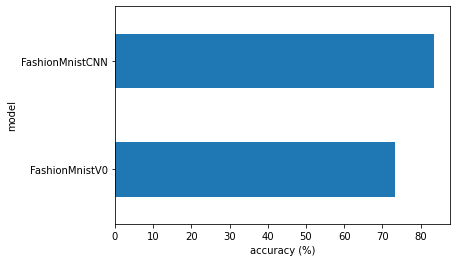

In [27]:
compare_result['model_acc'].plot(kind='barh')
plt.xlabel("accuracy (%)")
plt.ylabel("model");

In [127]:
from pathlib import Path

MODEL_PATH = Path('save_model')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'fashion_mnistv0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'save model to : {MODEL_SAVE_PATH}')
torch.save(model_v0.state_dict(), f=MODEL_SAVE_PATH)

save model to : save_model\fashion_mnistv0.pth


In [128]:
MODEL_NAME = 'fashion_mnistCNN.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'save model to : {MODEL_SAVE_PATH}')
torch.save(model_v1.state_dict(), f=MODEL_SAVE_PATH)

save model to : save_model\fashion_mnistCNN.pth


### Make and evaluate predictions

In [175]:
# load trained model
model_v0 = FashionMnistV0(input_shape=28*28, hidden_unit=10, output_shape=10)
model_v0.load_state_dict(torch.load(f=r'save_model\fashion_mnistv0.pth')) 

model_v1 = FashionMnistCNN(input_shape=1, hidden_units=8, output_shape=10)
model_v1.load_state_dict(torch.load(f=r'save_model\fashion_mnistCNN.pth')) 

<All keys matched successfully>

In [200]:
# modelv0
model_v0.eval()
pred_probas = []
preds = []
images = []
labels = []

with torch.inference_mode() :
    for X, y in test_dataloader :
        probas = model_v0(X)
        preds_ = torch.torch.argmax(probas, dim=1)
        
        pred_probas.append(probas)
        preds.append(preds_)
        images.append(X)
        labels.append(y)

In [201]:
pred_probas[0][0]

tensor([1.9939e-07, 1.5190e-10, 5.6517e-07, 1.8547e-06, 2.0887e-07, 1.4865e-02,
        3.6207e-07, 2.9642e-02, 1.7228e-04, 9.5532e-01])

In [202]:
# most 3 probas values
pred_probas[0][0][torch.argsort(pred_probas[0][0])[-3:]]

tensor([0.0149, 0.0296, 0.9553])

In [203]:
most_3_probas_ = []
for batch in pred_probas :
    for probas in batch :
        most_3_index = torch.argsort(probas)[-3:]
        most_3_probas = probas[most_3_index]
        most_3_probas_.append([most_3_index, most_3_probas])